### Cats vs Dogs Redux Based on fast.ai course

In [1]:
%pwd

u'/home/ubuntu/courses/deeplearning1/nbs/lesson1'

Directory setup

In [2]:
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_DIR = current_dir + '/data'

In [3]:
sys.path.insert(1, '../') 

In [4]:
from utils import *
from vgg16 import Vgg16

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [5]:
%matplotlib inline

## Action Plan
1. Create Validation and Sample Sets
2. Rearrange image files into their respective directories
3. Finetune and Train Model
4. Generate Predictions
5. Validate Predictions
6. Submit Predictions to Kaggle

### Create Validation and Sample Sets
Only need to run this the first time

In [6]:
!mkdir -p 'redux/train/cats'
!mkdir -p 'redux/train/dogs'
!mkdir -p 'redux/validation/cats'
!mkdir -p 'redux/validation/dogs'
!mkdir -p 'sample/train/cats'
!mkdir -p 'sample/train/dogs'
!mkdir -p 'sample/validation/cats'
!mkdir -p 'sample/validation/dogs'
!mkdir -p 'sample/test/unknown'
!mkdir -p 'data/train/cats'
!mkdir -p 'data/train/dogs'

In [33]:
import shutil
import glob
cat_files = glob.glob('data/train/cat*')
for cat_file in cat_files:
    shutil.move(cat_file, 'data/train/cats/')
dog_files = glob.glob('data/train/dog*')
for dog_file in dog_files:
    shutil.move(dog_file, 'data/train/dogs/')

Split data into train and validation sets

In [34]:
import random
train_split = 0.9
cat_files = glob.glob('data/train/cats/cat*')
for cat_file in cat_files:
    if random.random() >= train_split:
        shutil.copy(cat_file, 'redux/validation/cats/')
    else:
        shutil.copy(cat_file, 'redux/train/cats/')
dog_files = glob.glob('data/train/dogs/dog*')
for dog_file in dog_files:
    if random.random() >= train_split:
        shutil.copy(dog_file, 'redux/validation/dogs/')
    else:
        shutil.copy(dog_file, 'redux/train/dogs/')

Create sample sets

In [35]:
sample_size = 20
for cat_file in cat_files[0:sample_size]:
    if random.random() >= train_split:
        shutil.copy(cat_file, 'sample/validation/cats/')
    else:
        shutil.copy(cat_file, 'sample/train/cats/')    
for dog_file in dog_files[0:sample_size]:
    if random.random() >= train_split:
        shutil.copy(dog_file, 'sample/validation/dogs/')
    else:
        shutil.copy(dog_file, 'sample/train/dogs/')

In [10]:
test_files = glob.glob('data/test/unknown/*')
for test_file in test_files[0:sample_size]:
    shutil.copy(test_file, 'sample/test/unknown/')

### Fine tune and train model

In [6]:
#model_path = 'sample/'
model_path = 'redux/'

Generate extra images via generator

In [8]:
datagenerator = image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, vertical_flip = True)

In [9]:
model = Vgg16()
train_batch = model.get_batches(os.path.join(model_path, 'train'), datagenerator, batch_size=32)
validation_batch = model.get_batches(os.path.join(model_path, 'validation'))
model.finetune(train_batch)

Found 22507 images belonging to 2 classes.
Found 2493 images belonging to 2 classes.


In [12]:
model = Vgg16()
train_batch = model.get_batches(os.path.join(model_path, 'train'))
validation_batch = model.get_batches(os.path.join(model_path, 'validation'))
model.finetune(train_batch)

/Users/kwanchongtan/anaconda/lib/python3.5/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Found 33 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [11]:
model.model.load_weights('catsdogs2.h5')

In [ ]:
epochs = 10
for epoch in range(epochs):
    print("Running Epoch {}".format(epoch + 1))
    model.fit(train_batch, validation_batch)

Running Epoch 1
Epoch 1/1
 6496/22507 [=======>......................] - ETA: 402s - loss: 1.1337 - acc: 0.9078

In [13]:
epochs = 2
for epoch in range(epochs):
    print("Running Epoch {}".format(epoch + 1))
    model.fit(train_batch, validation_batch)

Running Epoch 0
Epoch 1/1
33/33 [==============================] - 10s - loss: 2.0549 - acc: 0.4545 - val_loss: 0.2013 - val_acc: 1.0000
Running Epoch 1
Epoch 1/1
33/33 [==============================] - 10s - loss: 0.4749 - acc: 0.8182 - val_loss: 0.0850 - val_acc: 1.0000


### Generate Predictions

In [14]:
test_dir = 'sample/test'
#test_dir = 'data/test'

In [15]:
test_batches, test_predictions = model.test(test_dir)

Found 20 images belonging to 1 classes.


### Validate Predictions

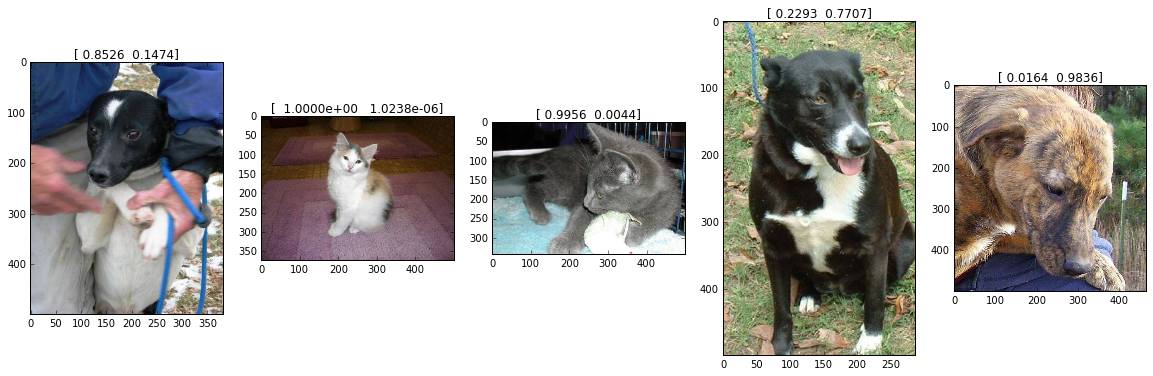

In [280]:
n = 5
f, axarr = plt.subplots(1, n, figsize=(20,100))
for i in range(n):
    img = plt.imread(os.path.join(test_dir, test_batches.filenames[i]))
    axarr[i].imshow(img)
    axarr[i].set_title("{}".format(test_predictions[i]))

### Submit Predictions to Kaggle

In [283]:
labels = np.clip(test_predictions[:,1], 0.0125, 0.9875)

In [289]:
ids = [filename.split("/")[1].split(".")[0] for filename in test_batches.filenames]

In [298]:
submission = np.column_stack([ids, labels])

In [299]:
np.savetxt('ksub.csv', submission, delimiter=',', header='id,label', fmt="%s", comments='')

In [300]:
from IPython.display import FileLink
FileLink('ksub.csv')

/Users/kwanchongtan/Repo/courses/deeplearning1/nbs/lesson1/ksub.csv